# Units Systems and Custom Conversion Index

### Objective

This will explain how skspec converts between various units (e.g. nm $\rightarrow$ hz) and how you can implement your own **Conversion Index objects**. We demonstrate this by building a `PressureIndex` to represent pressure as the perturbation in a spectroscopy experiment.

<font color='blue'>**If you are just adding a custom unit but don't need to convert between unit systems, use the simple approach**</font> presented in the [http://nbviewer.ipython.org/urls/raw.github.com/hugadams/skspec/master/examples/Notebooks/basic_units.ipynb](basic units tutorial).

### Environment Setup

Configure notebook style (see NBCONFIG.ipynb), add imports and paths.  The **%run** magic used below <font color='red'>**requires IPython 2.0 or higher.**</font>

In [1]:
%run NBCONFIG.ipynb

Populating the interactive namespace from numpy and matplotlib
['dti', 'd', 'h', 'm', 'us', 's', 'ms', 'intvl', 'ns']

/home/adam/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /home/adam/Canopy/appdata/canopy-1.4.0.1938.rh5-x86/lib/python2.7/argparse.pyc, but /home/adam/Enthought/Canopy_32bit/User/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream
/home/adam/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


### The SpecIndex

Let's take a look at a `TimeSpectra` and its underlying `SpecIndex`

In [2]:
from skspec.data import aunps_glass
ts=aunps_glass()

ts.index[0:3]

SpecIndex[nm]([430.1, 430.47, 430.85], dtype='float64')

Recall that we can convert to various unit systems:

In [3]:
ts.specunits

print ts.as_specunit('ev').index[0:3]
print ts.as_specunit('k').index[0:3]
print ts.as_specunit(None).index[0:3]

SpecIndex[ev]([2.88268243823, 2.88020469878, 2.87766442308], dtype='float64')
SpecIndex[k]([2325040.68821, 2323042.25614, 2320993.38517], dtype='float64')
SpecIndex[None]([430.1, 430.47, 430.85], dtype='float64')


Under the hood, `SpecIndex` is using a `convert()` method to transfer between the unit types.  Let's instantiate a SpecIndex() from scratch and convert units through the SpecIndex's API directly:

In [4]:
from skspec.core.specindex import SpecIndex

index = SpecIndex([1,2,3], unit='cm')
print index
print index.convert('nm')

SpecIndex[cm]([1.0, 2.0, 3.0], dtype='float64')
SpecIndex[nm]([10000000.0, 20000000.0, 30000000.0], dtype='float64')


### The TimeIndex

The `TimeIndex` is a slightly more complex Index (supports dtype=`object` and `float64` used to store interval representations of time.  It can store datetimes (timestamps), timedeltas and cumulative time intervals like the number of seconds passed.

In [5]:
ts.varunits()

{None: 'No unit',
 'd': 'days',
 'dti': 'timestamp',
 'h': 'hours',
 'intvl': 'interval',
 'm': 'minutes',
 'ms': 'milliseconds',
 'ns': 'nanoseconds',
 's': 'seconds',
 'us': 'microseconds'}

On the test data, we have stored timestamps:

In [6]:
ts.columns[0:5]

TimeIndex[dti]([2014-05-22 15:38:23, 2014-05-22 15:38:26, 2014-05-22 15:38:30, 2014-05-22 15:38:34, 2014-05-22 15:38:37], dtype='object')

We can convert these to timedeltas (`unit=intv`) or cumulative minutes (`unit=m`).

In [7]:
print ts.as_varunit('intvl').columns[0:5]
print ts.as_varunit('m').columns[0:5]


TimeIndex[intvl]([0:00:00, 0:00:03, 0:00:07, 0:00:11, 0:00:14], dtype='object')
TimeIndex[m]([0.0, 0.05, 0.116666666667, 0.183333333333, 0.233333333333], dtype='float64')


The TimeIndex stores metadata from the TimeStamps to let it regenerate the timestamp data after converting to an interval:

In [8]:
ts.as_varunit('m').as_varunit('dti').columns[0:5]

TimeIndex[dti]([2014-05-22 15:38:23, 2014-05-22 15:38:26, 2014-05-22 15:38:30, 2014-05-22 15:38:34, 2014-05-22 15:38:37], dtype='object')

Internally, the datetimeindex is stored in `ts.columns.datetimeindex`:

In [9]:
ts.columns.datetimeindex

<class 'pandas.tseries.index.DatetimeIndex'>
[2014-05-22 15:38:23, ..., 2014-05-22 15:44:25]
Length: 100, Freq: None, Timezone: None

### The Unit Class

`SpecIndex` and `TimeIndex` use stored `Units`, which are a special datastructure that contain all of the metadata of a particular unit system, including *conversion metadata.*  This is stored in the `_unit` attribute on the index.

In [10]:
print index._unit

The unit stores a short name, long name, mathematical symbol, and other metadata about the spectral unit, in this case **cm**:

In [11]:
u = index._unit
print u.short
print u.full
print u.symbol
print u.category

cm
centimeters
\lambda
wavelength


`TimeSpectra` plotting and printout will refer to this metadata for various formatting cases.  For example, in 2d correlation plots, the `unit.symbol` attribute is used for annotating the cross plot.

### Building a Custom Conversion Unit System

Imagine now we want to create an index that stores values of pressure, for example in Pascals.  To do so, we subclass from the `Unit` skspec baseclass:

In [12]:
from skspec.units.abcunits import ConversionUnit

class Pascal(ConversionUnit):
    short = 'pa'
    full = 'Pascals'
    symbol = 'r$\rho$' #For math rendering in certain plots
    _canonical = True
    
    def to_canonical(self, x):
       return x
      
    def from_canonical(self, x):
       return x

Ok, so let's try to understand this.  First, we created a new class called `Pascals` with various metadata.  If we needed the pressure unit system to have additional metadata or methods, we could have created an intermediate subclass, `PressureUnit`, but because we aren't adding any custom functionality, we'll subclass directly from `Unit`.  

Notice the use of `_canonical`.  This indicates that we choose Pascals as our primary pressure unit.  Therefore, when we do conversions from and to other pressure units, they will pass through Pascals.  This will be more clear when we make our next system of units.  In addition, the `to_canonical()` and `from_canonical()` are functions that convert an array from Pascals to the canonical pressure unit.  Since Pascals is the canonical unit, these don't actually do anything!

Now let's show what the class for `Atmosphere` units should look like.  Recall that to convert from **Pa** to **Atm**:

$1 atm = 1.01325 \times 10^{5} Pa$

Likewise, to convert from Atm to Pa:

$1 pa = 9.86923267 \times 10^{-6} atm$

In [13]:
Pa2Atm = 101325 #pa in 1 atm

class Atmosphere(ConversionUnit):
    short = 'atm'
    full = 'Atmospheres'
    symbol = 'r$\rho$' #For math rendering in certain plots
    
    def to_canonical(self, x):
       return x * Pa2Atm
      
    def from_canonical(self, x):
       return x / Pa2Atm

Notice that we've defined the conversion: $\;\;atm \rightarrow Pa\;\;\;$    via `to_canonical()` 

and

$Pa \rightarrow atm\;\;\;$ via `from_canonical()`.

Let's double check they are correct:

In [14]:
atm = Atmosphere()
print '1 atm to pa', atm.to_canonical(1.0)
print '1 pa to atm', atm.from_canonical(1.0)

1 atm to pa 101325.0
1 pa to atm 9.86923266716e-06


As expected, this also works on Numpy arrays:

In [15]:
atmospheres = np.linspace(1,5,5)

print 'atmospheres', atmospheres
print 'pascals', atm.to_canonical(atmospheres)

atmospheres [ 1.  2.  3.  4.  5.]
pascals [ 101325.  202650.  303975.  405300.  506625.]


#### Pressure units of Bars

We repeat this process for `Bars`.  Again, we only need to worry about converting to Pascals, the canonical unit.  <font color='blue'>**By going through the canonical unit, we don't have to worry about all of the various permutations of different units**</font>; defining `to_canonical()` and `from_canonical()` is sufficient.  Here's the correct class for Bars:

In [16]:
Pa2Bar = 100000 #pa in 1 bar

class Bar(ConversionUnit):
    short = 'b'
    full = 'Bars'
    symbol = 'r$\rho$' #For math rendering in certain plots
    
    def to_canonical(self, x):
       return x * Pa2Bar
      
    def from_canonical(self, x):
       return x / Pa2Bar
    
bunit = Bar()
bars = np.linspace(1,5,5)

print 'bars', bars
print 'pascals', bunit.to_canonical(bars)    

bars [ 1.  2.  3.  4.  5.]
pascals [ 100000.  200000.  300000.  400000.  500000.]


### Building the Custom Index

Alright, so we've defined our 3 new pressure units.  How do we make them into a valid Index object?  It's actually quite easy and only takes 2 steps:

#### Step 1: Make a Dicionary of Units

We need to take all of our new units and create a dictionary.  The keys of the dictionary should be the **short** attribute of the unit, and the values will refer to the objects themselves.  Something like:

In [17]:
pressure_units = [Atmosphere(), Bar(), Pascal()]
pressure_dict = dict((unit.short, unit) for unit in pressure_units)
pressure_dict

{'atm': <__main__.Atmosphere at 0xab661ec>,
 'b': <__main__.Bar at 0xab661cc>,
 'pa': <__main__.Pascal at 0xab6618c>}

#### Step 2:  Subclass the ConversionIndex class

skspec includes a `ConversionIndex` class that is designed for creating Indexes from Units as we've done.  All we need to do is sublcass and reference out `pressure_dict` dictionary that we've already created.  It's that simple:

In [18]:
from skspec.core.abcindex import ConversionFloat64Index

class PressureIndex(ConversionFloat64Index):
    unitdict = pressure_dict

#### Step 3: Test in it out

In [19]:
pindex = PressureIndex([1,2,3], unit='pa')
pindex

PressureIndex[pa]([1.0, 2.0, 3.0], dtype='float64')

In [20]:
print pindex.convert('atm')
print pindex.convert('b')
print pindex.convert(None)

PressureIndex[atm]([9.86923266716e-06, 1.97384653343e-05, 2.96076980015e-05], dtype='float64')
PressureIndex[b]([1e-05, 2e-05, 3e-05], dtype='float64')
PressureIndex[None]([1.0, 2.0, 3.0], dtype='float64')


### Adding our Index to a skspec Spectra

Since skspec Spectra are basically pandas dataframes, it should be easy to merely overwrite the Index with our custom objects; however, **skspec strictly enforces Index typing** in its basic Spectra and TimeSpectra classes.  This is a design choice to prevent novices from acidentally overwriting a spectral index with a pertubation index.  For example, overwriting the wavelengths with pressures, when strictly speaking, pressure should be the perturbation variable.   <font color='red'>**Trying it will give us an error:**</font>

In [21]:
# THIS SHOULD RAISE AN ERROR
ts.columns = PressureIndex(np.linspace(0,1,len(ts.index)), unit='atm')

SpecError: Invalid column type: <class '__main__.PressureIndex'>; require <class 'skspec.core.timeindex.TimeIndex'>.

#### Workaround 1: Remove this typing on TimeSpectra object creation

We can override the typecasting rules through the **strict_columns** and **strict_index** keywords.  Setting them to `False` will remove the dependency.  This is boilerplate that can be copied directly:

In [22]:
test = aunps_glass(specunit='nm')
test._strict_columns=False  #Bug, this isn't working as a keyword to aunps_glass() 

Try it out with the data from the previous TimeSpectra with the timecolumns replace with pressure units.

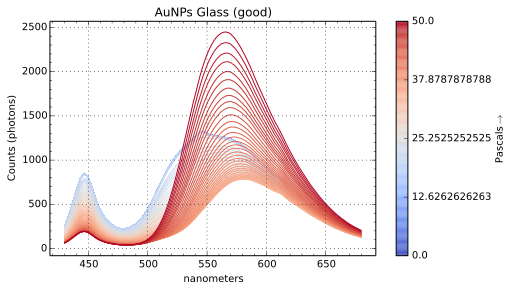

In [23]:
test.columns = PressureIndex(np.linspace(0,50,len(ts.columns)), unit='pa')
test.plot(cbar=True);

**The point of this example was to show that the strict-typing has been removed.**  Pressure as a spectral variable doesn't make much sense...

#### Workaround 2: Subclass Spectra

A permanent workaround is to create a new baseclass from **Spectra** that doesn't have this stringency.  We do this through the **force_columns** and **force_index** keywords.  Setting them to None will remove the typecasting, or we can set them to a different type, in this case `PressureIndex`:

In [24]:
from skspec.core.spectra import Spectra

class PressureSpectra(Spectra):
    """ Overwrite __init__ to force the perturbation variable to pressure """

    def __init__(self, *dfargs, **dfkwargs):
        dfkwargs.setdefault('strict_columns', PressureIndex)
        super(PressureSpectra, self).__init__(*dfargs, **dfkwargs)

We'll pass the same data and spectral index from the TimeSpectra, but the columns will be automatically converted to pressure units.  Because we pass no columns, pandas assigns values 0-100, and then skspec will float-convert and force into a pressure index.

PressureIndex[pa]([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0], dtype='float64')

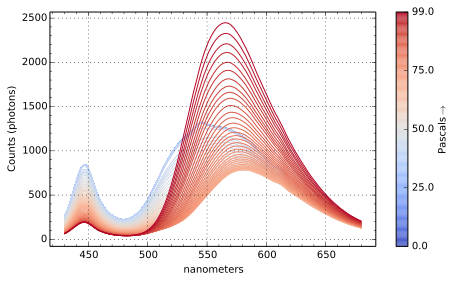

In [25]:
ps = PressureSpectra(data=np.array(ts.data),
                           index=ts.index,
                           varunit='pa',
                           )
ps.plot(cbar=True)
ps.columns

This should translate in general to the plotting and unit system API in skspec.

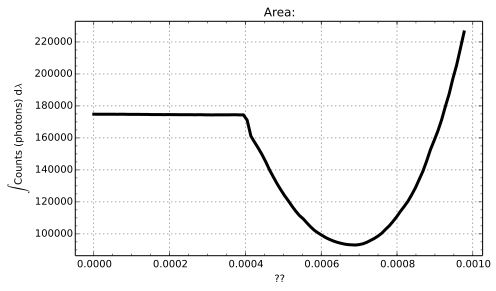

In [26]:
from skspec.plotting import areaplot
areaplot(ps.as_varunit('atm'));

### A Complete Example

Here is the code required (sans custom logging) to create the skspec `TempSpectra`:

In [29]:
"""Provides core "TempSpectra" class. """

from skspec.core.spectra import Spectra
from skspec.units import TEMPUNITS
from skspec.core.specindex import SpecIndex
from skspec.core.abcindex import ConversionFloat64Index

class TempIndex(ConversionFloat64Index):
   """ Temperature Index of Float64 values """
   unitdict = TEMPUNITS  

class TempSpectra(Spectra):
   """Spectral Index (rows) with Temperature Variation (columns) """
   def __init__(self, *dfargs, **dfkwargs):
      dfkwargs['strict_columns'] = TempIndex
      dfkwargs['strict_index'] = SpecIndex
      super(TempSpectra, self).__init__(*dfargs, **dfkwargs)

And to test it:

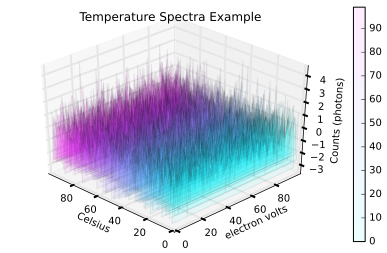

In [28]:
tempspec = TempSpectra(np.random.randn(100,100), 
                       specunit='ev',
                       varunit='C')

tempspec.plot(cbar=True,
              kind='waterfall',
              cmap='cool',
              title='Temperature Spectra Example');

<hr>
<br>


<div style="float:left; \">
    <img src="https://avatars0.githubusercontent.com/u/1972276?s=460" 
 align=left; text-align:center; style="float:left; margin-left: 5px; margin-top: -25px; width:150px; height:150px" /> 
</div>

<div style="float:left; \"><a href="https://github.com/hugadams">
    <img src="https://assets-cdn.github.com/images/modules/logos_page/GitHub-Mark.png" 
 align=left; text-align:center; style="float:left; margin-left: 25px; margin-top: -25px; width:75px; height:75px" /> 
</div>


<div style="float:left; \"><a href="https://twitter.com/hughesadam87">
    <img src="http://paymentmagnates.com/wp-content/uploads/2014/04/twitter-icon.png" 
 align=left; text-align:center; style="float:left; margin-left: 25px; margin-top: -25px; width:75px; height:75px" /> 
</div>

<div style="float:left; \"><a href="https://www.researchgate.net/profile/Adam_Hughes2?ev=hdr_xprf">
    <img src="http://www.txhughes.com/images/button-researchgate.png" 
 align=left; text-align:center; style="float:left; margin-left: -175px; margin-top: 55px; width:75px; height:75px" /> 
</div>

<div style="float:left; \"><a href="https://www.linkedin.com/profile/view?id=121484744&trk=nav_responsive_tab_profile_picg">
    <img src="http://smallbusinessesdoitbetter.com/wordpress/wp-content/uploads/li.png" 
 align=left; text-align:center; style="float:left; margin-left: -75px; margin-top: 55px; width:75px; height:75px" /> 
</div>

<div style="float:center; \"><a href="http://www.gwu.edu/">
    <img src="https://raw.githubusercontent.com/hugadams/pyparty/master/pyparty/data/gwu.png" 
 align=center style="float:center; margin-right: 30px; margin-top: -35px; width:335px; height:180px" />
</div>


<h4 style="margin-top:0px;"> This notebook is free for redistribution. If citing, please reference as: </h4>
- *Hughes, A. (2012). [A Computational Framework for Plasmonic Nanobiosensing](https://www.researchgate.net/publication/236672995_A_Computational_Framework_for_Plasmonic_Nanobiosensing).  Python in Science Conference [SCIPY].* 


<h3 style="margin-top:30px;"> Questions or Feedback? </h3>

* hugadams@gwmail.gwu.edu 
* twitter:  <a href="https://twitter.com/hughesadam87" target="_blank">@hughesadam87</a>
* <a href="http://www.gwu.edu/~condmat/CME/reeves.html" target="_blank">Mark Reeves Biophysics Group</a>




<h3 style="margin-top:30px;"> References: </h3>

* [1] : **REF 1**
* [2] : **REF 2**





<h3 style="margin-top:30px;"> Related: </h3>

   * <a href="https://github.com/hugadams/pyparty" target="_blank">skspec: Exploratory Spectral Data Analysis</a>
   * <a href="https://github.com/hugadams/pyparty" target="_blank">pyparty: Image Analysis of Particles</a>
   * <a href="http://lorenabarba.com/" target="_blank">Lorena A. Barba (GWU Engineering)</a>
   * <a href="http://www.youtube.com/watch?v=W7RgkHM-B60" target="_blank">xray: extended arrays for scientific datasets</a>



<h3 style="margin-top:30px;">Notebook styling ideas:</h3>

* <a href="http://blog.louic.nl/?p=683" target="_blank">Louic's web blog</a>
* <a href="https://plot.ly/feed" target="_blank">Plotly</a>
* <a href="http://damon-is-a-geek.com/publication-ready-the-first-time-beautiful-reproducible-plots-with-matplotlib.html" target="_blank">Publication-ready the first time: Beautiful, reproducible plots with Matplotlib</a>

<br>
<hr>